---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>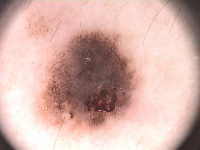</td><td>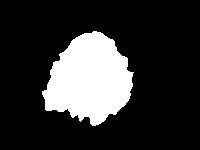</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2024-11-16 12:55:05--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-11-16 12:55:05--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ff088079270924e4874b52184.dl.dropboxusercontent.com/cd/0/inline/CeftC90ysSEOGmuRfhmaU7hbsnISS8P-kOo9L1hEiUtNMsXwCs6N5lKZsBry-cnMmzPtf-3OVNIlypll8g9ukZm8T7t2t2KRDGFVIshMwNDt9ckyjG38Dke4fuqO5Zjwn-A/file# [following]
--2024-11-16 12:55:06--  https://uc3ff088079270924e4874b52184.dl.dropboxusercontent.com/cd/0/inline/CeftC90ysSEOGmuR

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

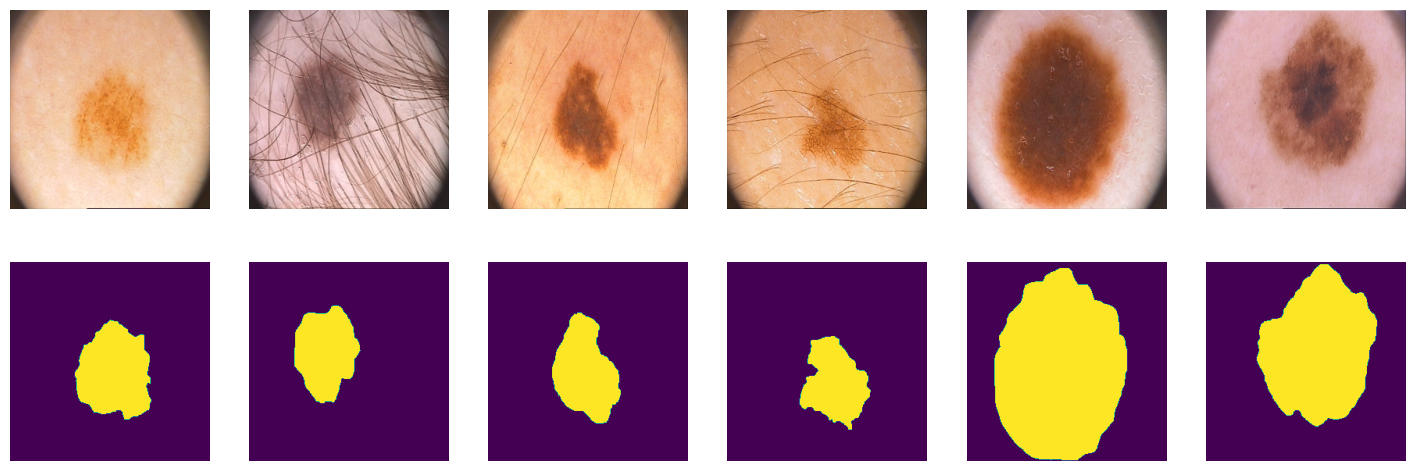

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet

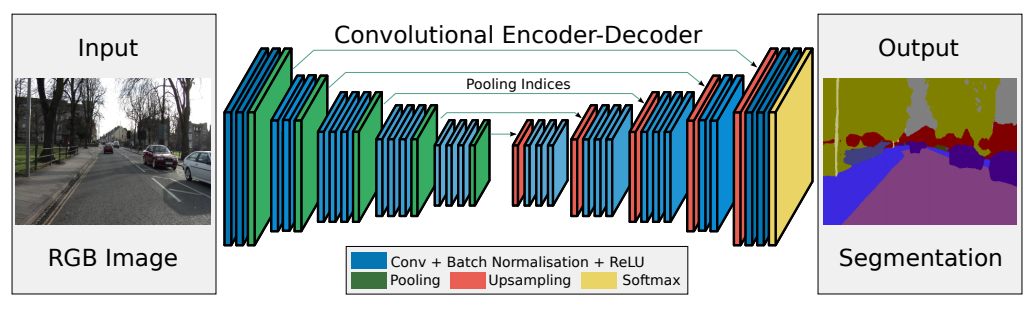

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(512, 512, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 8 -> 16
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 16 -> 32
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv4 = nn.Conv2d(32, 1, kernel_size=3, padding=1)  # Output for 2 classes (segmentation)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
        e4 = self.enc_conv4(self.pool3(e3))

        # bottleneck
        b = self.bottleneck_conv(self.pool4(e4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))
        d4 = self.dec_conv4(self.upsample4(d3))

        return d4  # Output layer for 2 classes


## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [15]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded



## Функция потерь

> Добавить блок с цитатой



Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [16]:
def bce_loss(y_pred, y_real):
    loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    return loss




## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from time import time
from IPython.display import clear_output

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()
        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()

            avg_loss += loss.item() / len(data_tr)

        train_losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            Y_val_pred = model(X_val.to(device))
            val_loss = loss_fn(Y_val_pred, Y_val.to(device)).item()
            val_losses.append(val_loss)

        toc = time()
        print('loss: %f - val_loss: %f' % (avg_loss, val_loss))

        Y_hat = Y_val_pred.detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f - val_loss: %f' % (epoch+1, epochs, avg_loss, val_loss))
        plt.show()

    return train_losses, val_losses


## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [18]:
def predict(model, data):
    model.eval()
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [19]:
def score_model(model, metric, data):
    model.eval()
    scores = 0
    scores_history = []
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        score = metric(torch.sigmoid(Y_pred) > 0.5, Y_label.to(device)).mean().item()
        scores += score
        scores_history.append(score)
    print('Average IoU metric score: {:.4f}'.format(scores/len(data)))
    return scores_history


## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [20]:
model = SegNet().to(device)

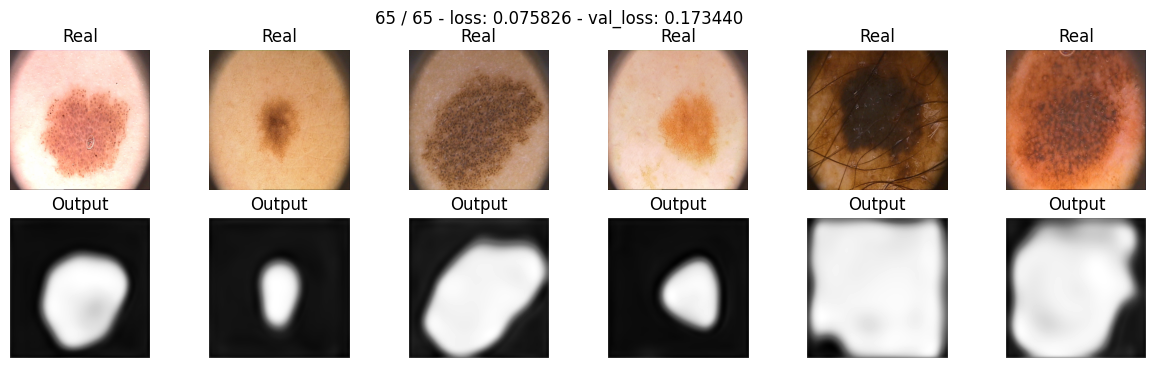

In [21]:
max_epochs = 65
optimize = torch.optim.Adam(model.parameters(), lr = 1e-4)

train_losses, val_losses = train(model, optimize, bce_loss, max_epochs, data_tr, data_val)

In [22]:
SeG_avg_score = score_model(model, iou_pytorch, data_val)

Average IoU metric score: 0.7000


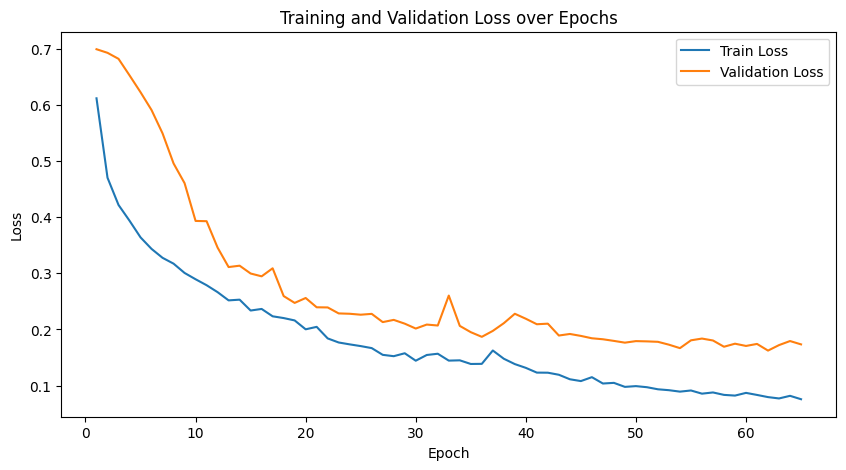

In [23]:

plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()



**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [24]:
def dice_loss(y_pred, y_real):
    smooth = 1e-6
    real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred)
    pred = y_pred.view(-1)

    num = torch.sum(real * pred)
    den = torch.sum(real + pred)
    res = 1 - torch.mean(2 * num/ (den + smooth))
    return res

Проводим тестирование:

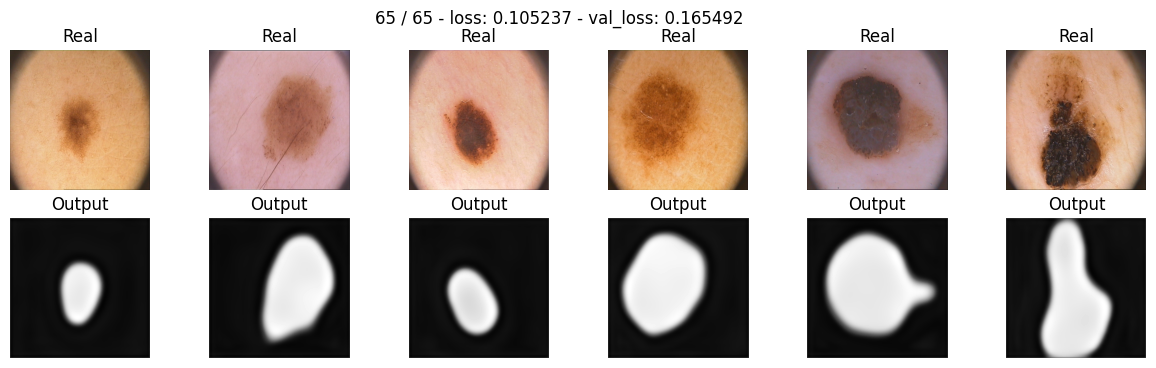

In [25]:
model_dice = SegNet().to(device)

max_epochs = 65
optimizer = torch.optim.Adam(model_dice.parameters(), lr = 1e-4)
train_loss_dice, val_loss_dice = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

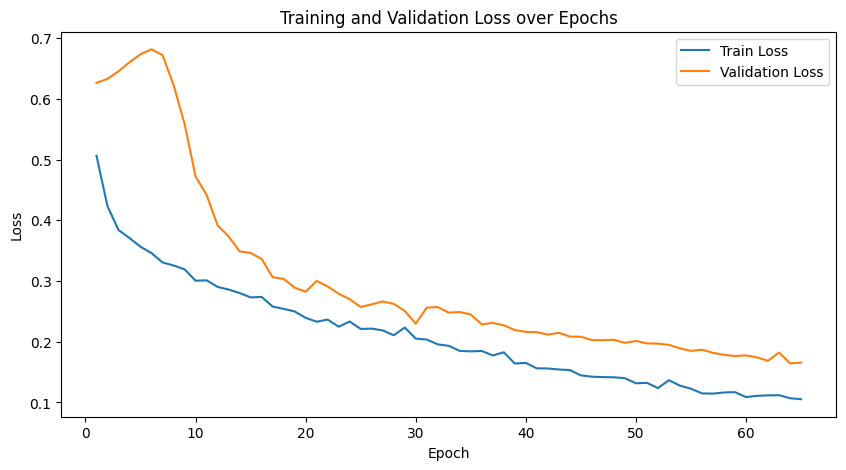

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_loss_dice, label='Train Loss')
plt.plot(range(1, max_epochs + 1), val_loss_dice, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [27]:
dice_avg_score = score_model(model_dice, iou_pytorch, data_val)

Average IoU metric score: 0.7020


[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [28]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, eps, 1) # hint: torch.clamp
    your_loss = 1 * (1 - torch.exp(-bce_loss(y_pred, y_real)))**gamma * bce_loss(y_pred, y_real)
    return your_loss


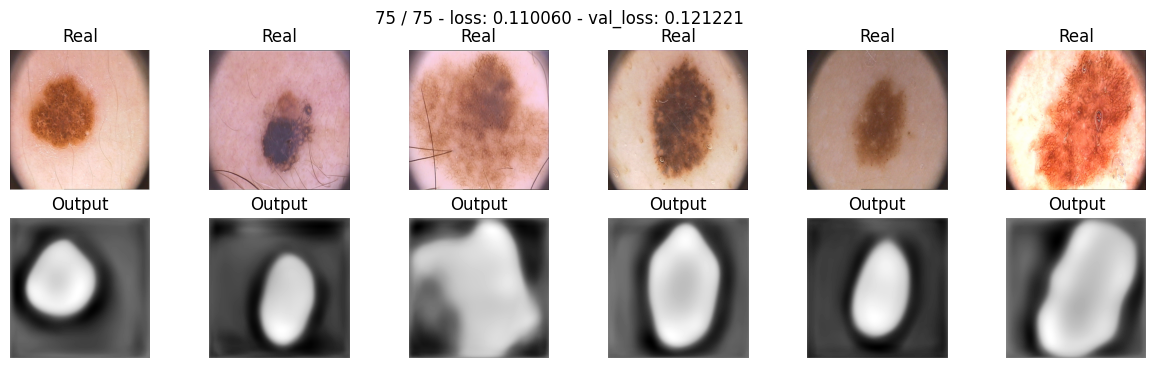

In [29]:
model_focal = SegNet().to(device)

max_epochs = 75
optimaizer = torch.optim.Adam(model_focal.parameters(), lr = 1e-4)
train_loss_focal, val_loss_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

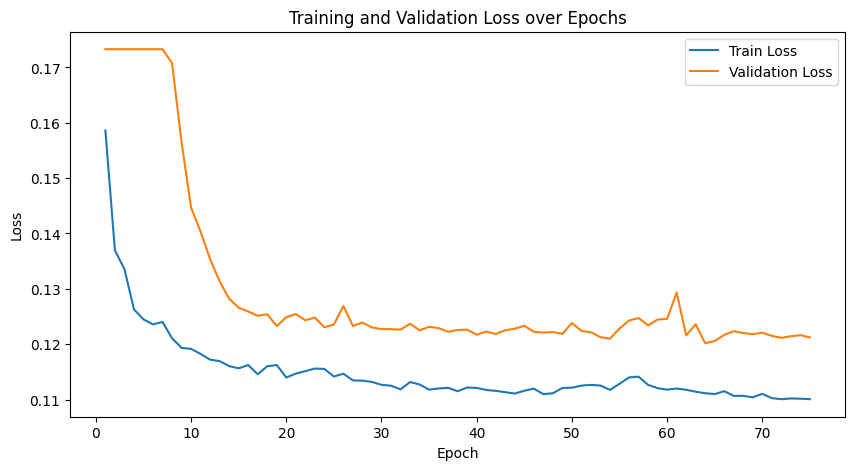

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_loss_focal, label='Train Loss')
plt.plot(range(1, max_epochs + 1), val_loss_focal, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [31]:
score_model(model_focal, iou_pytorch, data_val)

Average IoU metric score: 0.6980


[0.6800000071525574, 0.7160000205039978]

#Тверский лосс

In [32]:
def tversky_loss(y_pred, y_real, beta=0.7):
    smooth = 1e-6
    real = y_real.view(-1)
    y_pred = torch.sigmoid(y_pred)
    pred = y_pred.view(-1)

    TP = torch.sum(real * pred) # TP
    FP = torch.sum(pred * (1 - real)) # FP
    FN = torch.sum((1 - pred) * real) # FN
    tversky_loss = 1 - TP / (TP + beta * FP + (1 - beta) * FN + smooth)
    return torch.mean(tversky_loss)

In [33]:
model_segnet_tversky = SegNet().to(device)

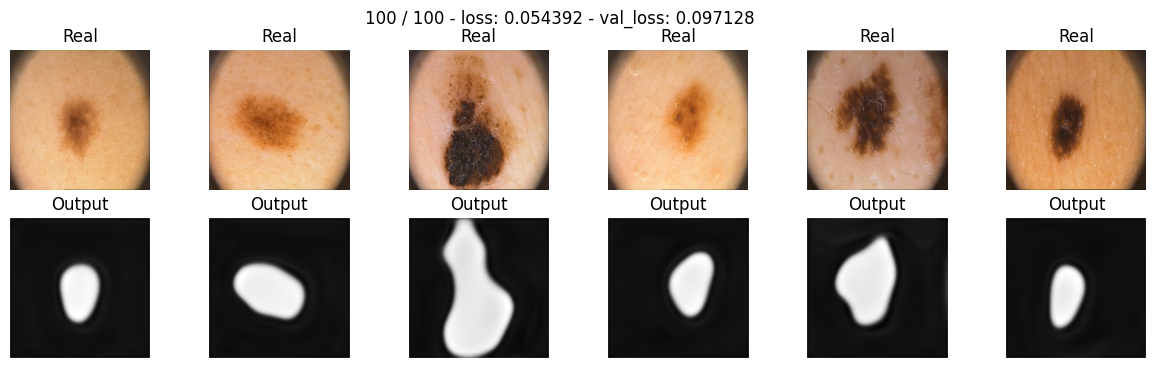

In [34]:
max_epochs = 100
optim = torch.optim.Adam(model_segnet_tversky.parameters(), lr=1e-4)
train_loss_tversky, val_loss_tversky = train(model_segnet_tversky, optim, tversky_loss, max_epochs, data_tr, data_val)

In [35]:
score_model(model_segnet_tversky, iou_pytorch, data_val)

Average IoU metric score: 0.7000


[0.7279999852180481, 0.6719999313354492]

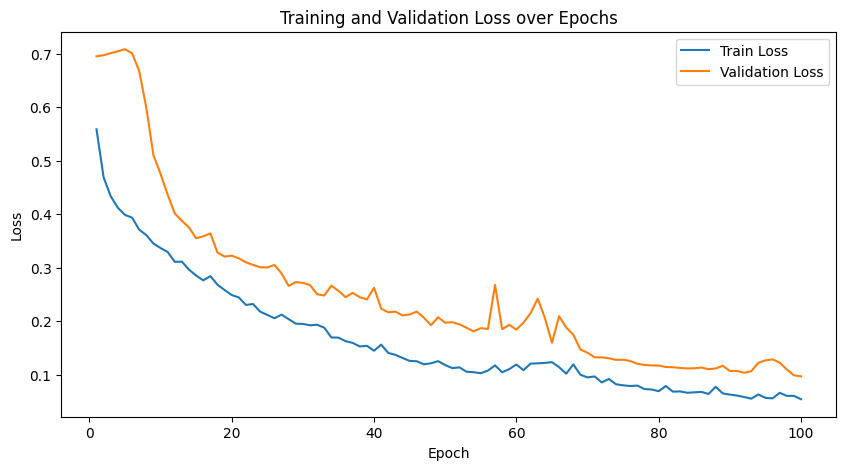

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_epochs + 1), train_loss_tversky, label='Train Loss')
plt.plot(range(1, max_epochs + 1), val_loss_tversky, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

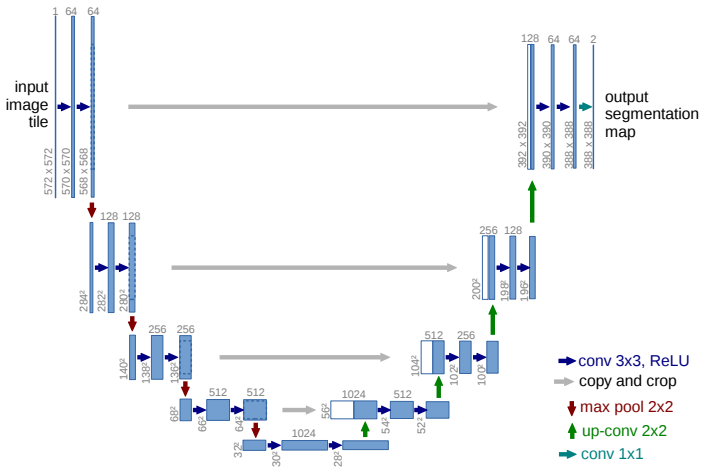

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [41]:


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        # Bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )

        # Decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
        )

        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 1, kernel_size=1),  # Final output layer
        )

    def forward(self, x):
        # Encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # Bottleneck
        b = self.bottleneck_conv(p3)

        # Decoder
        u0 = self.upsample0(b)
        d0 = self.dec_conv0(torch.cat([u0, e3], dim=1))
        u1 = self.upsample1(d0)
        d1 = self.dec_conv1(torch.cat([u1, e2], dim=1))
        u2 = self.upsample2(d1)
        d2 = self.dec_conv2(torch.cat([u2, e1], dim=1))
        u3 = self.upsample3(d2)
        d3 = self.dec_conv3(torch.cat([u3, e0], dim=1))  # No activation at the end

        return d3


In [38]:
unet_model = UNet().to(device)


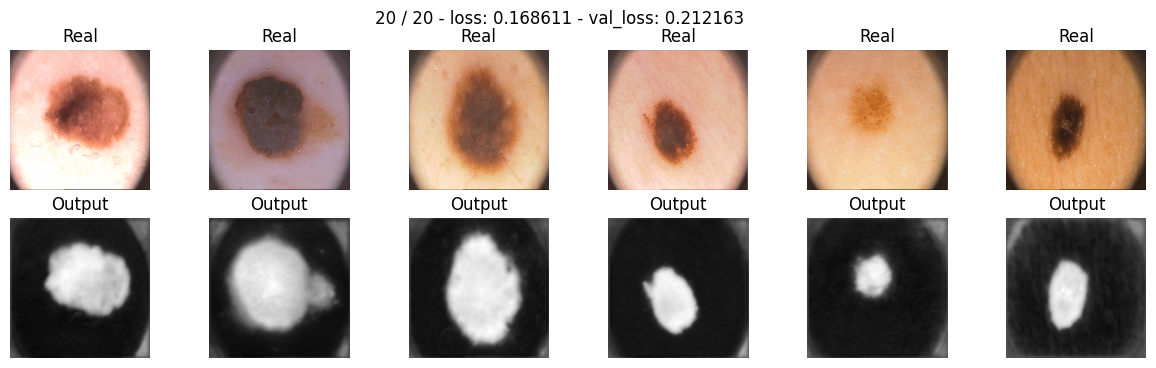

([0.6023053824901581,
  0.46358589828014374,
  0.40118682384490967,
  0.33967311680316925,
  0.28613562136888504,
  0.269881758838892,
  0.2533075138926506,
  0.2300310805439949,
  0.22048252075910568,
  0.1854647435247898,
  0.18443679064512253,
  0.19609196856617928,
  0.2221078872680664,
  0.18766354396939278,
  0.17668383568525314,
  0.15759463608264923,
  0.17205207981169224,
  0.16339018195867538,
  0.14963770285248756,
  0.16861141100525856],
 [0.71162348985672,
  0.7183675169944763,
  0.7103465795516968,
  0.6791133880615234,
  0.6347329020500183,
  0.5540130138397217,
  0.4953729510307312,
  0.37083113193511963,
  0.32502907514572144,
  0.38102400302886963,
  0.7540112137794495,
  0.30659621953964233,
  0.19971837103366852,
  0.2522246837615967,
  0.24377931654453278,
  0.2731771469116211,
  0.2069859653711319,
  0.1869508922100067,
  0.18120251595973969,
  0.21216273307800293])

In [39]:
train(unet_model, torch.optim.Adam(unet_model.parameters(),lr = 1e-4), bce_loss, 20, data_tr, data_val)